In [1]:
import os 
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"# Using device: {device}")

# Using device: cuda


In [3]:
torch.cuda.empty_cache()

In [4]:
patch = np.load('patch.npy',allow_pickle=True)
mask = np.load('mask.npy',allow_pickle=True)

len(patch), len(mask)

(55, 55)

In [5]:
patch.shape, mask.shape

((55, 256, 256, 3), (55, 256, 256, 3))

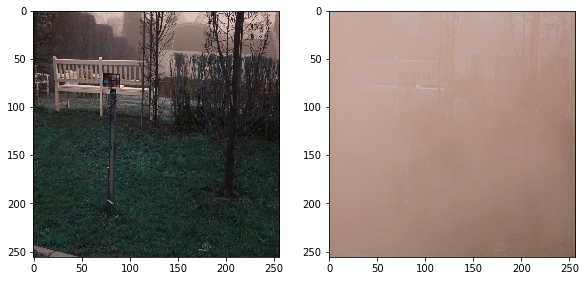

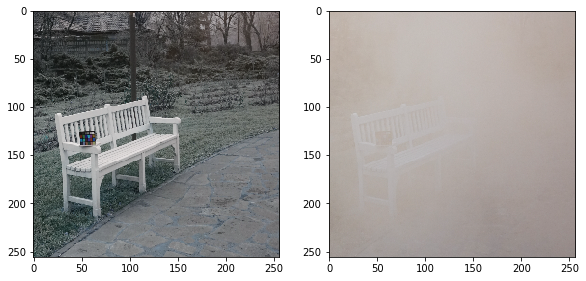

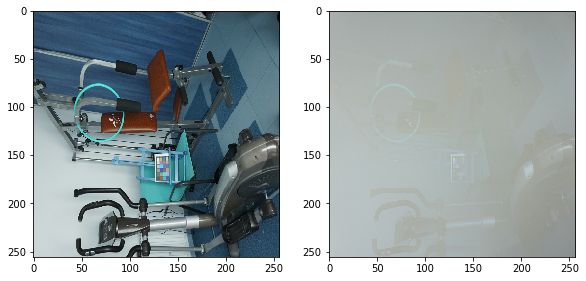

In [6]:
for i in range(0,len(patch),20):
    
    fig=plt.figure(figsize=(15, 5))
    
    ax = plt.subplot(131)
    plt.imshow(patch[i])
    
    ax = plt.subplot(132)
    plt.imshow(mask[i])
    plt.show()

In [8]:
IMG_SIZE=256

EPOCHS = 1000
batch_size = 1
learning_rate = 0.0005

In [9]:
patch_loader = torch.utils.data.DataLoader(dataset=patch,batch_size=batch_size,shuffle=False)

for data in patch_loader:
    print(data.size())
    print(type(data))
    break

torch.Size([1, 256, 256, 3])
<class 'torch.Tensor'>


In [10]:
X_orig=torch.Tensor([patch[i] for i in range(len(patch))])
X_hazy=torch.Tensor([mask[i] for i in range(len(mask))])

X_orig=X_orig/255
X_hazy=X_hazy/255

In [12]:
print('X_orig: ',X_orig.size())

X_orig_T=np.transpose(X_orig,(0,3,1,2))
X_hazy_T=np.transpose(X_hazy,(0,3,1,2))
print('X_orig_T: ',X_orig_T.shape)

X_orig_flat=X_orig_T.reshape(-1,1,IMG_SIZE,IMG_SIZE)
X_hazy_flat=X_hazy_T.reshape(-1,1,IMG_SIZE,IMG_SIZE)
print('X_orig_flat: ',X_orig_flat.shape)

X_orig:  torch.Size([55, 256, 256, 3])
X_orig_T:  torch.Size([55, 3, 256, 256])
X_orig_flat:  torch.Size([165, 1, 256, 256])


In [13]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),             
                        nn.Conv2d(32,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 128 x 128
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 64 x 64
                        nn.ReLU()
        )
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out
    
encoder = Encoder().cuda()

In [14]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,64,64)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda()

In [15]:
# Check output of autoencoder

train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_flat,batch_size=batch_size,shuffle=False)
train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)

for train_orig, train_hazy in zip(train_orig_loader, train_hazy_loader):
    orig_image = Variable(train_orig).cuda()
    hazy_image = Variable(train_hazy).cuda()
    
    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)
    
    print('Image Dim: ',orig_image.size())
    print('Hazy Image Dim: ',hazy_image.size())
    print('Encoder Output Dim: ',encoder_op.size())
    print('Output Dim: ',output.size())
    break

Image Dim:  torch.Size([1, 1, 256, 256])
Hazy Image Dim:  torch.Size([1, 1, 256, 256])
Encoder Output Dim:  torch.Size([1, 1048576])
Output Dim:  torch.Size([1, 1, 256, 256])


In [16]:
encoder, decoder = torch.load('models/dehaze_autoencoder.pkl')

In [17]:
train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)

dehazed_output=[]
for train_hazy in tqdm(train_hazy_loader):
    hazy_image = Variable(train_hazy).cuda()
    
    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)
    
    output=output.cpu()
    output=output.detach()
    dehazed_output.append(output)

100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [00:06<00:00, 26.22it/s]


In [18]:
X_dehazed=dehazed_output

X_dehazed=torch.stack(X_dehazed)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,1,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,3,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.permute(0,2,3,1)
print(X_dehazed.shape)

torch.Size([165, 1, 1, 256, 256])
torch.Size([165, 1, 256, 256])
torch.Size([55, 3, 256, 256])
torch.Size([55, 256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


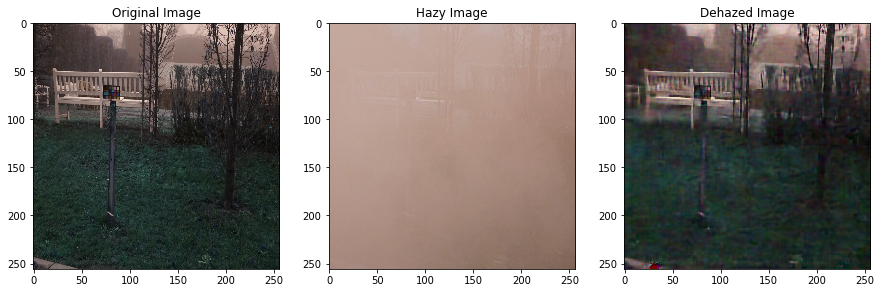

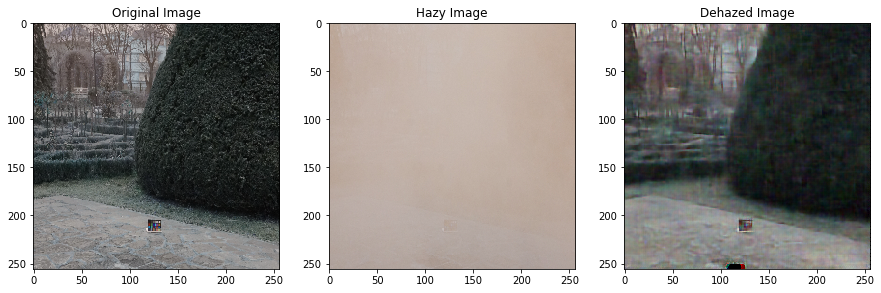

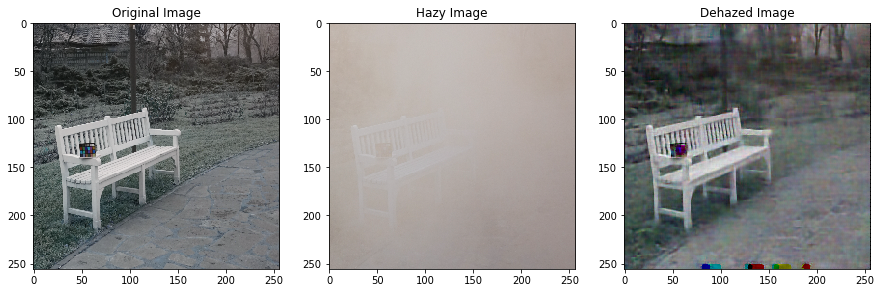

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


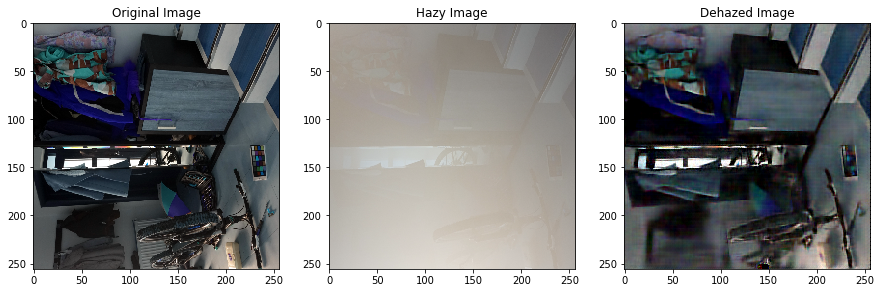

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


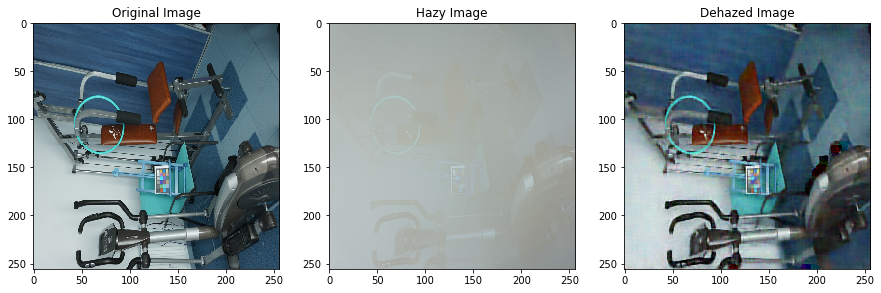

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


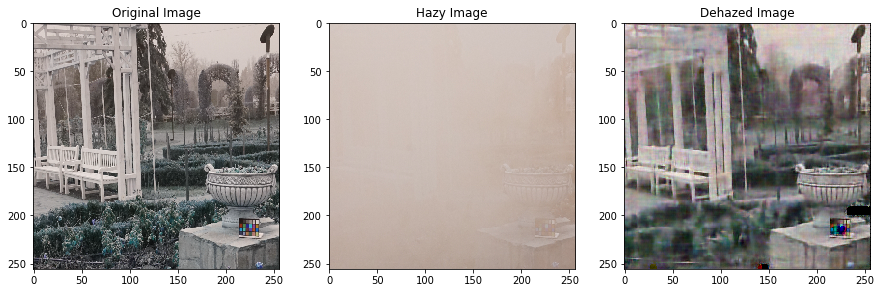

In [19]:
for i in range(0,len(X_orig),10):
    
    fig=plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(X_orig[i])
    
    ax = plt.subplot(132)
    plt.title('Hazy Image')
    plt.imshow(X_hazy[i])
    
    ax = plt.subplot(133)
    plt.title('Dehazed Image')
    plt.imshow(X_dehazed[i])
    plt.show()

## **`EVALUATION`**

In [20]:
X_dehazed=X_dehazed.numpy()
X_orig=X_orig.numpy()

X_orig=X_orig*255
X_dehazed=X_dehazed*255

ref_mat=X_orig
res_mat=X_dehazed

print(ref_mat.shape)
print(res_mat.shape)

(55, 256, 256, 3)
(55, 256, 256, 3)


In [21]:
ref_mat = ref_mat.astype('float') / 255.0
res_mat = res_mat.astype('float') / 255.0

def output_psnr_mse(img_orig, img_out):
    squared_error = np.square(img_orig - img_out)
    mse = np.mean(squared_error)
    psnr = 10 * np.log10(1.0 / mse)
    return psnr

def mean_psnr_srgb(ref_mat, res_mat):
    n_blk, h, w, c = ref_mat.shape
    mean_psnr = 0
    for b in range(n_blk):
        ref_block = ref_mat[b, :, :, :]
        res_block = res_mat[b, :, :, :]
        ref_block = np.reshape(ref_block, (h, w, c))
        res_block = np.reshape(res_block, (h, w, c))
        psnr = output_psnr_mse(ref_block, res_block)
        mean_psnr += psnr
    return mean_psnr / n_blk

#PSNR
mean_psnr = mean_psnr_srgb(ref_mat, res_mat)
print('mean_psnr:')
print(mean_psnr)

mean_psnr:
23.54620495797897


In [22]:
from skimage.metrics import structural_similarity as ssim

def mean_ssim_srgb(ref_mat, res_mat):
    n_blk, h, w, c = ref_mat.shape
    mean_ssim = 0
    for b in range(n_blk):
        ref_block = ref_mat[b, :, :, :]
        res_block = res_mat[b, :, :, :]
        ref_block = np.reshape(ref_block, (h, w, c))
        res_block = np.reshape(res_block, (h, w, c))
        ssim1 = ssim(ref_block, res_block, gaussian_weights=True, use_sample_covariance=False,
                     multichannel=True)
        mean_ssim += ssim1
    return mean_ssim / n_blk

# SSIM
mean_ssim = mean_ssim_srgb(ref_mat, res_mat)
print('mean_ssim:')
print(mean_ssim)

mean_ssim:
0.7383081613059929


## **`TESTING`**

Testing on random images taken from google

In [23]:
test_path='test_images/'

X_test=[]
for f in os.listdir(test_path):
    img = cv2.imread(test_path+f)
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    X_test.append(img)

In [24]:
X_test = torch.Tensor(X_test)
X_test = X_test/255

X_test_orig = X_test

X_test.size()

torch.Size([5, 256, 256, 3])

In [25]:
X_test = X_test.permute(0,3,1,2)
X_test = X_test.reshape(-1,1,IMG_SIZE,IMG_SIZE)
X_test.size()

torch.Size([15, 1, 256, 256])

In [26]:
test_img_loader = torch.utils.data.DataLoader(dataset=X_test,batch_size=batch_size,shuffle=False)

dehazed_output=[]
for test_img in test_img_loader:
    hazy_image = Variable(test_img).cuda()
    
    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)
    
    output=output.cpu()
    output=output.detach()
    dehazed_output.append(output)

In [27]:
X_dehazed=dehazed_output

X_dehazed=torch.stack(X_dehazed)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,1,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,3,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.permute(0,2,3,1)
print(X_dehazed.shape)

torch.Size([15, 1, 1, 256, 256])
torch.Size([15, 1, 256, 256])
torch.Size([5, 3, 256, 256])
torch.Size([5, 256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


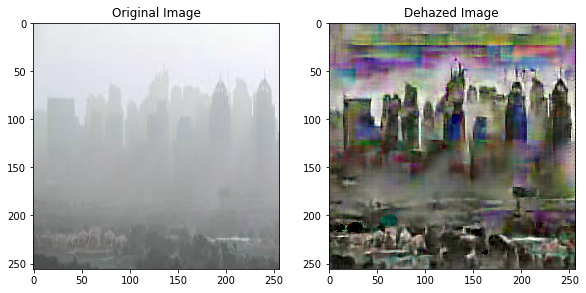

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


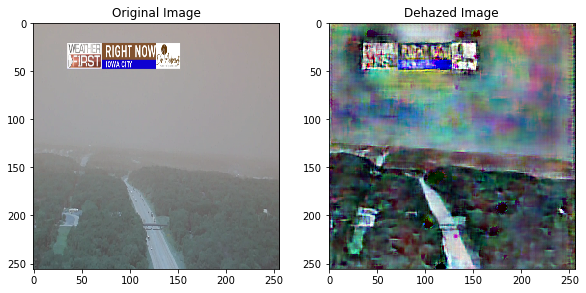

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


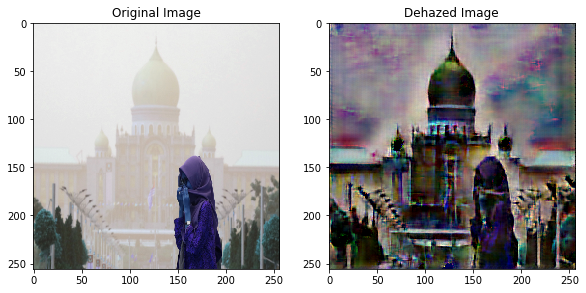

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


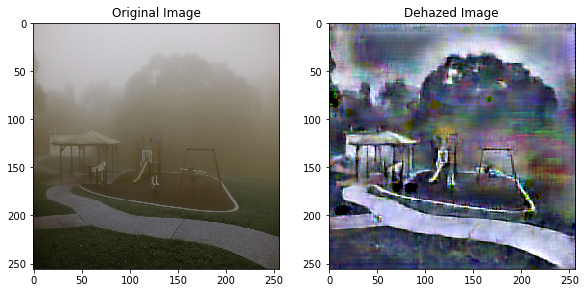

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


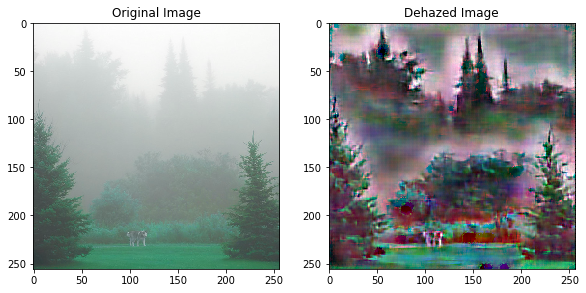

In [28]:
for i in range(0,len(X_test_orig)):
    
    fig=plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(X_test_orig[i])
    
    ax = plt.subplot(132)
    plt.title('Dehazed Image')
    plt.imshow(X_dehazed[i])
    plt.show()

In [29]:
X_test_orig = X_test_orig.numpy()
X_dehazed = X_dehazed.numpy()

X_test_orig=X_test_orig*255
X_dehazed=X_dehazed*255

ref_mat=X_test_orig
res_mat=X_dehazed

ref_mat = ref_mat.astype('float') / 255.0
res_mat = res_mat.astype('float') / 255.0

#PSNR
mean_psnr = mean_psnr_srgb(ref_mat, res_mat)
print('mean_psnr:')
print(mean_psnr)

# SSIM
mean_ssim = mean_ssim_srgb(ref_mat, res_mat)
print('mean_ssim:')
print(mean_ssim)

mean_psnr:
10.244191284684433
mean_ssim:
0.5378115434324828
